In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\yotam hermon\Anacond

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [4]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [5]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
#x=Dense(256,activation='relu')(x) #dense layer 4
preds=Dense(2,activation='softmax',activity_regularizer=regularizers.l2(1e-5))(x) #final layer with softmax activation

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [6]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [7]:
for layer in model.layers[:70]:
    layer.trainable=False
for layer in model.layers[70:]:
    layer.trainable=True

In [8]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('../data/train/classification/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True)

Found 2970 images belonging to 2 classes.


In [9]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=5)


Epoch 1/5
92/92 [==============================] - 8s 87ms/step - loss: 0.4807 - accuracy: 0.8274 0s - loss: 0.4850 - accuracy: 
Epoch 2/5
92/92 [==============================] - 5s 59ms/step - loss: 0.3662 - accuracy: 0.8434
Epoch 3/5
92/92 [==============================] - 5s 60ms/step - loss: 0.3110 - accuracy: 0.8642
Epoch 4/5
92/92 [==============================] - 5s 59ms/step - loss: 0.2438 - accuracy: 0.8894 0s - loss: 0.2491 - 
Epoch 5/5
92/92 [==============================] - 5s 59ms/step - loss: 0.1863 - accuracy: 0.9173


In [10]:
print (model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [11]:
def validation(model, train_datagen):
    #model=Model(inputs=base_model.input,outputs=preds)
    #model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
    val_generator=train_datagen.flow_from_directory('../data/validation/', # this is where you specify the path to the main data folder
                                                     target_size=(224,224),
                                                     color_mode='rgb',
                                                     batch_size=32,
                                                     class_mode='categorical',                                                 
                                                     shuffle=True)

    step_size_val=val_generator.n//val_generator.batch_size
    history1 = model.fit_generator(generator=val_generator,
                       steps_per_epoch=step_size_val,
                       epochs=5)
    return history1

In [12]:
history1 = validation(model,train_datagen)

Found 120 images belonging to 2 classes.
Epoch 1/5
3/3 [==============================] - 1s 205ms/step - loss: 1.4078 - accuracy: 0.5682
Epoch 2/5
3/3 [==============================] - 0s 59ms/step - loss: 0.5210 - accuracy: 0.7292
Epoch 3/5
3/3 [==============================] - 0s 80ms/step - loss: 0.3415 - accuracy: 0.9205
Epoch 4/5
3/3 [==============================] - 0s 54ms/step - loss: 0.1631 - accuracy: 0.9659
Epoch 5/5
3/3 [==============================] - 0s 52ms/step - loss: 0.0986 - accuracy: 0.9545


In [13]:
base_model2=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model2.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
#x=Dense(256,activation='relu')(x) #dense layer 4
preds=Dense(2,activation='softmax',activity_regularizer=regularizers.l2(1e-5))(x) #final layer with softmax activation

model2=Model(inputs=base_model2.input,outputs=preds)

for layer in model2.layers[:40]:
    layer.trainable=False
for layer in model2.layers[40:]:
    layer.trainable=True

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('../data/train/classification/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True)

model2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size=train_generator.n//train_generator.batch_size
history2 = model2.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size,
                   epochs=5)

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Found 2970 images belonging to 2 classes.
Epoch 1/5
92/92 [==============================] - 9s 97ms/step - loss: 0.4727 - accuracy: 0.8278
Epoch 2/5
92/92 [==============================] - 8s 84ms/step - loss: 0.3520 - accuracy: 0.8455
Epoch 3/5
92/92 [==============================] - 8s 85ms/step - loss: 0.3127 - accuracy: 0.8611 2s - loss: 0.2
Epoch 4/5
92/92 [==============================] - 8s 85ms/step - loss: 0.2564 - accuracy: 0.8948
Epoch 5/5
92/92 [==============================] - 8s 85ms/step - loss: 0.2042 - accuracy: 0.9129


In [22]:
print (model2.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [14]:
history_noisedVal = validation(model2,train_datagen)

Found 120 images belonging to 2 classes.
Epoch 1/5
3/3 [==============================] - 0s 95ms/step - loss: 1.5996 - accuracy: 0.5455
Epoch 2/5
3/3 [==============================] - 0s 83ms/step - loss: 0.5653 - accuracy: 0.7188
Epoch 3/5
3/3 [==============================] - 0s 79ms/step - loss: 0.4994 - accuracy: 0.7386
Epoch 4/5
3/3 [==============================] - 0s 75ms/step - loss: 0.4649 - accuracy: 0.7159
Epoch 5/5
3/3 [==============================] - 0s 74ms/step - loss: 0.3585 - accuracy: 0.7955


In [15]:
base_model3=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model3.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
#x=Dense(256,activation='relu')(x) #dense layer 4
preds=Dense(2,activation='softmax',activity_regularizer=regularizers.l2(1e-5))(x) #final layer with softmax activation

model3=Model(inputs=base_model3.input,outputs=preds)

for layer in model3.layers[:10]:
    layer.trainable=False
for layer in model3.layers[10:]:
    layer.trainable=True

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('../data/train/classification/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True)

model3.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size=train_generator.n//train_generator.batch_size
history3 = model3.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size,
                   epochs=5)

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Found 2970 images belonging to 2 classes.
Epoch 1/5
92/92 [==============================] - 16s 172ms/step - loss: 0.4638 - accuracy: 0.8302
Epoch 2/5
92/92 [==============================] - 14s 152ms/step - loss: 0.3646 - accuracy: 0.8445
Epoch 3/5
92/92 [==============================] - 14s 152ms/step - loss: 0.3149 - accuracy: 0.8666
Epoch 4/5
92/92 [==============================] - 14s 152ms/step - loss: 0.2716 - accuracy: 0.8836
Epoch 5/5
92/92 [==============================] - 14s 151ms/step - loss: 0.2611 - accuracy: 0.9003


In [23]:
print (model3.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [17]:
history_timeshiftVal = validation(model3,train_datagen)

Found 120 images belonging to 2 classes.
Epoch 1/5
3/3 [==============================] - 1s 205ms/step - loss: 1.2382 - accuracy: 0.5000
Epoch 2/5
3/3 [==============================] - 0s 136ms/step - loss: 0.6026 - accuracy: 0.5909
Epoch 3/5
3/3 [==============================] - 0s 147ms/step - loss: 0.5619 - accuracy: 0.8542
Epoch 4/5
3/3 [==============================] - 0s 141ms/step - loss: 0.4948 - accuracy: 0.7500
Epoch 5/5
3/3 [==============================] - 0s 136ms/step - loss: 0.3043 - accuracy: 0.8523


In [18]:
base_model4=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model4.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
#x=Dense(256,activation='relu')(x) #dense layer 4
preds=Dense(2,activation='softmax',activity_regularizer=regularizers.l2(1e-5))(x) #final layer with softmax activation

model4=Model(inputs=base_model4.input,outputs=preds)

for layer in model4.layers[:20]:
    layer.trainable=False
for layer in model4.layers[20:]:
    layer.trainable=True

train_datagen4=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator_snp=train_datagen4.flow_from_directory('../data/train/pepper_and_sault_spectrogram/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True)

model4.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_snp=train_generator_snp.n//train_generator_snp.batch_size
history4 = model4.fit_generator(generator=train_generator_snp,
                   steps_per_epoch=step_size_snp,
                   epochs=5)

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Found 1283 images belonging to 2 classes.
Epoch 1/5
40/40 [==============================] - 6s 161ms/step - loss: 0.4918 - accuracy: 0.8361
Epoch 2/5
40/40 [==============================] - 4s 109ms/step - loss: 0.2697 - accuracy: 0.8689
Epoch 3/5
40/40 [==============================] - 4s 110ms/step - loss: 0.2330 - accuracy: 0.9025
Epoch 4/5
40/40 [==============================] - 4s 109ms/step - loss: 0.1805 - accuracy: 0.9369
Epoch 5/5
40/40 [==============================] - 4s 109ms/step - loss: 0.2656 - accuracy: 0.9113


In [19]:
history_snpVal = validation(model4,train_datagen)

Found 120 images belonging to 2 classes.
Epoch 1/5
3/3 [==============================] - 0s 114ms/step - loss: 1.0569 - accuracy: 0.4886
Epoch 2/5
3/3 [==============================] - 0s 109ms/step - loss: 0.6720 - accuracy: 0.5682
Epoch 3/5
3/3 [==============================] - 0s 104ms/step - loss: 0.6389 - accuracy: 0.8068
Epoch 4/5
3/3 [==============================] - 0s 107ms/step - loss: 0.5592 - accuracy: 0.7917
Epoch 5/5
3/3 [==============================] - 0s 109ms/step - loss: 0.4898 - accuracy: 0.7727


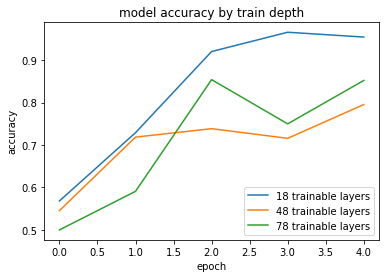

In [31]:
plt.plot(history1.history['accuracy'])
plt.plot(history_noisedVal.history['accuracy'])
plt.plot(history_timeshiftVal.history['accuracy'])
plt.title('model accuracy by train depth')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['18 trainable layers', '48 trainable layers', '78 trainable layers'], loc='lower right')
plt.show()

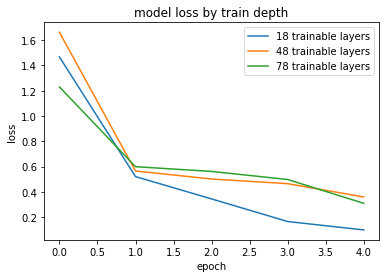

In [32]:
plt.plot(history1.history['loss'])
plt.plot(history_noisedVal.history['loss'])
plt.plot(history_timeshiftVal.history['loss'])
plt.title('model loss by train depth')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['18 trainable layers', '48 trainable layers', '78 trainable layers'], loc='upper right')
plt.show()